<a href="https://colab.research.google.com/github/trungLeHoang/LVTN/blob/main/Load_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Code LVTN dự đoán thời gian sống của pin

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import scipy.io

## Define Load Data functions from NASA Dataset

In [ ]:
def build_files(folder_to_exclude, src_dir=os.getcwd()):
    data_folder = os.path.join(src_dir, 'data')
    dict_files = {}
    for directory in os.listdir(data_folder):
        fullpath_dir = os.path.join(data_folder, directory)
        if os.path.isdir(fullpath_dir) and directory not in folder_to_exclude:
            dict_files[directory] = [os.path.join(fullpath_dir, file) for file
                                     in os.listdir(fullpath_dir) if
                                     file.endswith('.mat')]

    return dict_files

In [ ]:
def _convert_matlab_datetime_vector_to_utc(date_vector):
    """Convert matlab datetime format into a UTC format"""
    # f'{val:02}' TODO
    string_time = str(int(date_vector[0])) + "-" + \
        f'{int(date_vector[1]):02}' + "-" + \
        f'{int(date_vector[2]):02}' + "T" + \
        f'{int(date_vector[3]):02}' + ":" + \
        f'{int(date_vector[4]):02}' + ":" + \
        f'{float(date_vector[5]):06.3f}'

    return string_time


def _format_temperature(temp):
    """There are 3 main temparatures, if they are close we want to put them in the same category"""
    # /!\Disclaimer/!\ This is completly related to the NASA battery dataset.
    if temp < 6:
        return 4
    elif temp < 26:
        return 24
    else:
        return 43

In [ ]:
def extract_charge_from_item(item):
    dict_item = {}

    dict_item["test_type"] = item[0][0]  # charge impedence discharge
    dict_item["ambiant_temp"] = _format_temperature(item[1][0][0])  # temperature: 4 ~24 ~43
    dict_item["datetime"] = _convert_matlab_datetime_vector_to_utc(item[2][0])

    dict_item["voltage_measured"] = item[3][0][0][0][0]  # Battery terminal voltage (Volts) floats
    dict_item["current_measured"] = item[3][0][0][1][0]  # Battery output current (Amps) floats
    dict_item["temperature_measured"] = item[3][0][0][2][0]  # Battery temperature (degree C) floats
    dict_item["current_charge"] = item[3][0][0][3][0]  # Current measured at charger (Amps) floats
    dict_item["voltage_charge"] = item[3][0][0][4][0]  # Voltage measured at charger (Volts) floats
    # MEH
    dict_item["time"] = item[3][0][0][5][0]  # Time vector for the cycle (secs) floats

    return dict_item


def extract_discharge_from_item(item):
    dict_item = {}

    dict_item["test_type"] = item[0][0]  # charge impedence discharge
    dict_item["ambiant_temp"] = _format_temperature(item[1][0][0])  # temperature: 4 ~24 ~43
    dict_item["datetime"] = _convert_matlab_datetime_vector_to_utc(item[2][0])

    dict_item["voltage_measured"] = item[3][0][0][0][0]  # Battery terminal voltage (Volts) floats
    dict_item["current_measured"] = item[3][0][0][1][0]  # Battery output current (Amps) flaots
    dict_item["temperature_measured"] = item[3][0][0][2][0]  # Battery temperature (degree C) floats
    dict_item["current_charge"] = item[3][0][0][3][0]  # Current measured at charger (Amps) floats
    dict_item["voltage_charge"] = item[3][0][0][4][0]  # Voltage measured at charger (Volts) floats
    # MEH
    dict_item["time"] = item[3][0][0][5][0]  # Time vector for the cycle (secs) floats
    dict_item["capacity"] = item[3][0][0][6][0]  # Battery capacity (Ahr) for discharge till 2.7V float_

    return dict_item


def extract_impedance_from_item(item):
    dict_item = {}

    dict_item["test_type"] = item[0][0]  # charge impedence discharge
    dict_item["ambiant_temp"] = _format_temperature(item[1][0][0])  # temperature: 4 ~24 ~43
    dict_item["datetime"] = _convert_matlab_datetime_vector_to_utc(item[2][0])

    dict_item["sense_current"] = item[3][0][0][0][0]  # Current in sense branch (Amps)| Complexes
    dict_item["sense_current_real"] = np.array([complx.real for complx in dict_item["sense_current"]])
    dict_item["sense_current_imag"] = np.array([complx.imag for complx in dict_item["sense_current"]])

    dict_item["battery_current"] = item[3][0][0][1][0]  # Current in battery branch (Amps)| Complexes
    dict_item["battery_current_real"] = np.array([complx.real for complx in dict_item["battery_current"]])
    dict_item["battery_current_imag"] = np.array([complx.imag for complx in dict_item["battery_current"]])

    dict_item["current_ratio"] = item[3][0][0][2][0]  # Ratio of the above currents| Complexes
    dict_item["current_ratio_real"] = np.array([complx.real for complx in dict_item["current_ratio"]])
    dict_item["current_ratio_imag"] = np.array([complx.imag for complx in dict_item["current_ratio"]])

    # Battery impedance (Ohms) computed from raw data| Complexes
    dict_item["battery_impedance"] = np.array([val[0] for val in item[3][0][0][3]])
    dict_item["battery_impedance_real"] = np.array([complx.real for complx in dict_item["battery_impedance"]])
    dict_item["battery_impedance_imag"] = np.array([complx.imag for complx in dict_item["battery_impedance"]])

    # Calibrated and smoothed battery impedance (Ohms)| Complexes
    dict_item["rectified_impedance"] = np.array([val[0] for val in item[3][0][0][4]])
    dict_item["rectified_impedance_real"] = np.array([complx.real for complx in dict_item["rectified_impedance"]])
    dict_item["rectified_impedance_imag"] = np.array([complx.imag for complx in dict_item["rectified_impedance"]])

    dict_item["re"] = item[3][0][0][5][0][0]  # Estimated electrolyte resistance (Ohms)| float_
    dict_item["rct"] = item[3][0][0][6][0][0]  # Estimated charge transfer resistance (Ohms)| float_

    return dict_item

In [ ]:
def _filter_mat(mat, test_type):
    """Keep only one type (e.g. impedance) from the matlab file"""
    return [x for x in mat if x[0][0] == test_type]


def _split_mat(mat):
    """Split matlab file into charge/discharge/impedance"""
    raw_charge_items = _filter_mat(mat, "charge")
    raw_discharge_items = _filter_mat(mat, "discharge")
    raw_impedance_items = _filter_mat(mat, "impedance")

    return raw_charge_items, raw_discharge_items, raw_impedance_items


def _load_mat_file(filepath):
    """Load the matlab file"""
    filename = os.path.split(filepath)[-1].split(".")[0]
    raw_mat = scipy.io.loadmat(filepath)
    mat = raw_mat[filename][0][0][0][0]

    return mat

In [ ]:
def extract_charge_discharge_impedance(filepath):
    mat = _load_mat_file(filepath)

    raw_charge_items, raw_discharge_items, raw_impedance_items = _split_mat(mat)

    charge_items = [extract_charge_from_item(raw_charge) for raw_charge in raw_charge_items]
    discharge_items = [extract_discharge_from_item(raw_discharge) for raw_discharge in raw_discharge_items]
    impedance_items = [extract_impedance_from_item(raw_impedance) for raw_impedance in raw_impedance_items]

    return charge_items, discharge_items, impedance_items

In [ ]:
def extract_charge_items(charge, battery_nb, charge_nb):
    df_charge = pd.DataFrame(
        columns=['battery_nb', 'datetime', 'charge_nb',
                 'voltage_measured', 'current_measured',
                 'temperature_measured', 'current_charge',
                 'voltage_charge', 'ambiant_temp']
    )
    df_charge['voltage_measured'] = charge['voltage_measured']
    df_charge['current_measured'] = charge['current_measured']
    df_charge['temperature_measured'] = charge[
        'temperature_measured']
    df_charge['current_charge'] = charge['current_charge']
    df_charge['voltage_charge'] = charge['voltage_charge']
    df_charge['ambiant_temp'] = charge['ambiant_temp']
    df_charge['battery_nb'] = [battery_nb] * len(
        charge['voltage_measured'])
    df_charge['charge_nb'] = [charge_nb] * len(
        charge['voltage_measured'])
    df_charge['datetime'] = pd.Timestamp(
        charge['datetime']) + pd.to_timedelta(charge['time'],
                                              unit='s')

    return df_charge


def extract_discharge_items(discharge, battery_nb, discharge_nb):
    df_discharge = pd.DataFrame(
        columns=['battery_nb', 'datetime', 'discharge_nb',
                 'voltage_measured', 'current_measured',
                 'temperature_measured', 'current_charge',
                 'voltage_charge', 'capacity', 'ambiant_temp']
    )
    df_discharge['voltage_measured'] = discharge[
        'voltage_measured']
    df_discharge['current_measured'] = discharge[
        'current_measured']
    df_discharge['temperature_measured'] = discharge[
        'temperature_measured']
    df_discharge['current_charge'] = discharge['current_charge']
    df_discharge['voltage_charge'] = discharge['voltage_charge']
    df_discharge['capacity'] = discharge['capacity'][0] if len(
        discharge['capacity']) > 0 else [np.NaN] * len(
        discharge['voltage_measured'])
    df_discharge['ambiant_temp'] = discharge['ambiant_temp']
    df_discharge['battery_nb'] = [battery_nb] * len(
        discharge['voltage_measured'])
    df_discharge['discharge_nb'] = [discharge_nb] * len(
        discharge['voltage_measured'])
    df_discharge['datetime'] = pd.Timestamp(
        discharge['datetime']) + pd.to_timedelta(
        discharge['time'], unit='s')

    return df_discharge

In [ ]:
def mat_to_pandas(files, bat_to_keep):
    df = pd.DataFrame()
    for folder_name, filepaths in files.items():
        for filepath in filepaths:
            battery_nb = int(
                os.path.splitext(os.path.basename(filepath))[0].replace('B', '')
            )
            charge_nb = 1
            discharge_nb = 1

            if battery_nb in bat_to_keep:
                charge_items, discharge_items, impedance_items = extract_charge_discharge_impedance(filepath)

                for charge in charge_items:
                    df_charge = extract_charge_items(charge, battery_nb, charge_nb)
                    df = df.append(df_charge, ignore_index=True, sort=False)

                    charge_nb = charge_nb + 1

                for discharge in discharge_items:
                    df_discharge = extract_discharge_items(discharge, battery_nb, discharge_nb)
                    df = df.append(df_discharge, ignore_index=True, sort=False)

                    discharge_nb = discharge_nb + 1
    print("Datas loaded !")
    return df

## Chuẩn hóa dữ liệu

In [ ]:

def get_splitted_datas(df):
  """cross_validation with 3 cross"""
  reach_cv_threshold = 0.02 # once the charge_voltage reach cv closer to this threshold, we say it reach cv
  # thresold_voltage_constant=0.05 # so voi 5 tk phia sau
  baterys=df['battery_nb'].astype('category').values.categories
  batery={} #dictionary store blocks of 
  for b in baterys:
    index=0
    data=df.loc[df['battery_nb']==b]
    cycles=data['charge_nb'].astype('category').values.categories # quantity cycles
    extract_points=[0.35,  0.52,  0.70,  0.88,  0.90,  0.92,  0.94,  0.96,  0.98,  0.99,  1] 
    data_batery=[]
    cv=4.2
    # drop first, last cycle
    for i in range(1,len(cycles)-2):
      cycle=data.loc[data['charge_nb']==cycles[i]]
      data_cycle=[]
      
      #x2, x3
      x2=0
      x3=0
      k=0 # cv position
      for c in range(2,len(cycle)):
        if (cycle['voltage_measured'].iloc[c]-cv)**2 < reach_cv_threshold**2:
          k=c
          break
      for c in range(2,len(cycle)):
        if c<k:
          x2+=cycle['current_measured'].iloc[c]
        else:
          x3+=cycle['current_measured'].iloc[c]

      #x4, x5
      x4=cycle.iloc[len(cycle)-1]['voltage_measured']
      x5=cycle.iloc[len(cycle)-1]['current_measured']

      #capacity
      capacity=data.loc[data['discharge_nb']==cycles[i]]['capacity'].iloc[0]
      #peak
      peak=0
      peak_threshold = 1.004
      temp_mean = 0
      if i>5:
        for j in range(5):
          temp_mean = temp_mean + data.loc[data['discharge_nb']==cycles[i-j]]['capacity'].iloc[0]
        temp_mean=temp_mean/5
        if capacity>temp_mean*peak_threshold:
          peak=1

      # [U, I, T, x2, x3, x4, x5, capacity, peak] x 11
      for x in extract_points:
        point=[]
        point.append(cycle.iloc[int(x*len(cycle))-1]['voltage_measured'])
        point.append(cycle.iloc[int(x*len(cycle))-1]['current_measured'])
        point.append(cycle.iloc[int(x*len(cycle))-1]['temperature_measured'])
        point.append(x2)
        point.append(x3)
        point.append(x4)
        point.append(x5)
        point.append(capacity)
        point.append(peak)
        data_cycle.append(point)
      # add info 1 cycle
      data_batery.append(data_cycle)
    batery[str(b)]=data_batery
  return batery

In [ ]:
def generate_X_Y_peak(X_train): #to move peak to output
  n, s, f = X_train.shape
  n_cycle = 10
  n_next_cycle = 2
  n_output_data = 2 # one for soh, one for peak
  X = np.zeros((n-n_cycle +1 - n_next_cycle, n_cycle, s, f))
  Y = np.zeros((n-n_cycle +1 - n_next_cycle, n_next_cycle, n_output_data))
  for i in range(len(X)):
    X[i] = X_train[i:i+n_cycle,:,:]
    Y[i,0,0] = X_train[i+n_cycle,0,-1]
    Y[i,0,1] = X_train[i+n_cycle+1,0,-1]
    Y[i,1,0] = X_train[i+n_cycle,0,-2]
    Y[i,1,1] = X_train[i+n_cycle+1,0,-2]
  return X, Y


In [ ]:
def normalized_col(df):
    normalized_col = (df-df.min())/(df.max()-df.min())
    return normalized_col

def min_max_normalize_data(df):
  normalized_df = df.copy()
  normalized_df['voltage_measured'] = normalized_col(normalized_df['voltage_measured'])
  normalized_df['current_measured'] = normalized_col(normalized_df['current_measured'])
  normalized_df['temperature_measured'] = normalized_col(normalized_df['temperature_measured'])
  normalized_df['capacity'] = normalized_col(normalized_df['capacity'])
  return normalized_df

In [ ]:
def get_data_frame(
        folder_to_exclude=['BatteryAgingARC-FY08Q4'],
        batteries_to_keep=[5,6,7,18],
        # batteries_to_keep=[5],
        src_dir="/content/drive/MyDrive/Colab_Notebooks"
):
    dict_files = build_files(
        folder_to_exclude=folder_to_exclude,
        src_dir=src_dir
    )
    df = mat_to_pandas(files=dict_files, bat_to_keep=batteries_to_keep)
    # normalized_df = min_max_normalize_data(df)
    return df

In [ ]:
df = get_data_frame()

In [ ]:
a=get_splitted_datas(df)

### Test data output

In [ ]:
print(len(a['5']))#167 cycles
print(len(a['5'][0]))# 11 points
len(a['5'][0][0])# 9 features

167
11


9

In [ ]:
print(len(a['6']))#167 cycles
print(len(a['6'][0]))# 11 points
len(a['6'][0][0])# 9 features

167
11


9

In [ ]:
print(len(a['7']))#167 cycles
print(len(a['7'][0]))# 11 points
len(a['7'][0][0])# 9 features

167
11


9

In [ ]:
print(len(a['18']))#167 cycles
print(len(a['18'][0]))# 11 points
len(a['18'][0][0])# 9 features

131
11


9

In [ ]:
data_set_5=np.array(a['5'])
data_set_5.shape

(167, 11, 9)

In [ ]:
data_set_6=np.array(a['6'])
data_set_6.shape

(167, 11, 9)

In [ ]:
data_set_7=np.array(a['7'])
data_set_7.shape

(167, 11, 9)

In [ ]:
data_set_18=np.array(a['18'])
data_set_18.shape

(131, 11, 9)

In [ ]:
for i in range(len(data_set_18)):
  for j in range(len(data_set_18[i])):
    for k in range(len(data_set_18[i][j])):
      if np.isnan(data_set_18[i][j][k]):
        print(i)

44
44
44
44
44
44
44
44
44
44
44


In [ ]:
data_set_18=np.delete(data_set_18,(44),axis=0)

In [ ]:
data_set_18.shape

(130, 11, 9)

In [ ]:
X_5,Y_5 =generate_X_Y_peak(data_set_5)
X_6,Y_6 =generate_X_Y_peak(data_set_6)
X_7,Y_7 =generate_X_Y_peak(data_set_7)
X_18,Y_18 =generate_X_Y_peak(data_set_18)

In [ ]:
X_5.shape

(156, 10, 11, 9)

In [ ]:
X_6.shape

(156, 10, 11, 9)

In [ ]:
X_7.shape

(156, 10, 11, 9)

In [ ]:
X_18.shape

(119, 10, 11, 9)

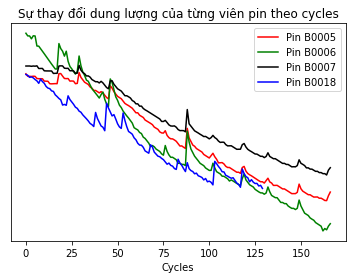

In [ ]:

import matplotlib.pyplot as plt
plt.plot(data_set_5[:,0,7],label='Pin B0005',color='red')
plt.plot(data_set_6[:,0,7],label='Pin B0006',color='green')
plt.plot(data_set_7[:,0,7],label='Pin B0007',color='black')
plt.plot(data_set_18[:,0,7],label='Pin B0018',color='blue')
plt.xlabel('Cycles')
plt.yticks([])
plt.title('Sự thay đổi dung lượng của từng viên pin theo cycles')
plt.legend(loc='best')
plt.show()

### Cross Validation


*   X_train, Y_train
*   X_val, Y_val
*   X_test, Y_test














In [ ]:
cross = [0.2, 0.4, 0.7, 1] 
first_167=round(cross[0]*X_5.shape[0])
second_167=round(cross[1]*X_5.shape[0])
third_167=round(cross[2]*X_5.shape[0])

first_131=round(cross[0]*X_18.shape[0])
second_131=round(cross[1]*X_18.shape[0])
third_131=round(cross[2]*X_18.shape[0])
#####
#                         "Cross 1"
#####
#X_test, Y_test
X_test= X_5[:first_167]  
X_test=np.concatenate((X_test, X_6[first_167:second_167]), axis=0)     
X_test=np.concatenate((X_test, X_7[second_167:third_167]), axis=0)     
X_test=np.concatenate((X_test, X_18[third_131:]), axis=0) 

Y_test= Y_5[:first_167]   
Y_test=np.concatenate((Y_test, Y_6[first_167:second_167]), axis=0)  
Y_test=np.concatenate((Y_test, Y_7[second_167:third_167]), axis=0) 
Y_test=np.concatenate((Y_test, Y_18[third_131:]), axis=0)      

#X_train, Y_train
X_train=X_5[first_167:third_167]                                                                     
X_train=np.concatenate((X_train, X_6[:first_167]), axis=0)                              
X_train=np.concatenate((X_train, X_6[second_167:third_167]), axis=0)  
X_train=np.concatenate((X_train, X_7[:second_167]), axis=0)                        
X_train=np.concatenate((X_train, X_18[:second_131]), axis=0)    

Y_train=Y_5[first_167:third_167]    
Y_train=np.concatenate((Y_train, Y_6[:first_167]), axis=0)                              
Y_train=np.concatenate((Y_train, Y_6[second_167:third_167]), axis=0)  
Y_train=np.concatenate((Y_train, Y_7[:second_167]), axis=0)                        
Y_train=np.concatenate((Y_train, Y_18[:second_131]), axis=0)  

#X_val, T_val
X_val=X_5[third_167:]
X_val=np.concatenate((X_val, X_6[third_167:]), axis=0)   
X_val=np.concatenate((X_val, X_7[third_167:]), axis=0) 
X_val=np.concatenate((X_val, X_18[second_131:third_131]), axis=0) 

Y_val=Y_5[third_167:]
Y_val=np.concatenate((Y_val, Y_6[third_167:]), axis=0)   
Y_val=np.concatenate((Y_val, Y_7[third_167:]), axis=0) 
Y_val=np.concatenate((Y_val, Y_18[second_131:third_131]), axis=0) 

#####
#                         "Cross 2"
#####
#X_test, Y_test
X_test= np.concatenate((X_test, X_5[:first_167]), axis=0) 
X_test=np.concatenate((X_test, X_6[first_167:second_167]), axis=0)     
X_test=np.concatenate((X_test, X_7[second_167:third_167]), axis=0)     
X_test=np.concatenate((X_test, X_18[third_131:]), axis=0) 

Y_test= np.concatenate((Y_test, Y_5[:first_167]), axis=0)   
Y_test=np.concatenate((Y_test, Y_6[first_167:second_167]), axis=0)  
Y_test=np.concatenate((Y_test, Y_7[second_167:third_167]), axis=0) 
Y_test=np.concatenate((Y_test, Y_18[third_131:]), axis=0)      

#X_train, Y_train
X_train=np.concatenate((X_train, X_5[first_167:second_167]), axis=0)                                                                     
X_train=np.concatenate((X_train, X_5[third_167:]), axis=0)                              
X_train=np.concatenate((X_train, X_6[:first_167]), axis=0) 
X_train=np.concatenate((X_train, X_6[third_167:]), axis=0)   
X_train=np.concatenate((X_train, X_7[:first_167]), axis=0) 
X_train=np.concatenate((X_train, X_7[third_167:]), axis=0)                         
X_train=np.concatenate((X_train, X_18[:first_131]), axis=0)    
X_train=np.concatenate((X_train, X_18[second_131:third_131]), axis=0) 

Y_train=np.concatenate((Y_train, Y_5[first_167:second_167]), axis=0)                                                                     
Y_train=np.concatenate((Y_train, Y_5[third_167:]), axis=0)                              
Y_train=np.concatenate((Y_train, Y_6[:first_167]), axis=0) 
Y_train=np.concatenate((Y_train, Y_6[third_167:]), axis=0)   
Y_train=np.concatenate((Y_train, Y_7[:first_167]), axis=0) 
Y_train=np.concatenate((Y_train, Y_7[third_167:]), axis=0)                         
Y_train=np.concatenate((Y_train, Y_18[:first_131]), axis=0)    
Y_train=np.concatenate((Y_train, Y_18[second_131:third_131]), axis=0)  

#X_val, T_val
X_val=np.concatenate((X_val, X_5[second_167:third_167]), axis=0)  
X_val=np.concatenate((X_val, X_6[second_167:third_167]), axis=0)   
X_val=np.concatenate((X_val, X_7[first_167:second_167]), axis=0) 
X_val=np.concatenate((X_val, X_18[first_131:second_131]), axis=0) 

Y_val=np.concatenate((Y_val, Y_5[second_167:third_167]), axis=0)  
Y_val=np.concatenate((Y_val, Y_6[second_167:third_167]), axis=0)   
Y_val=np.concatenate((Y_val, Y_7[first_167:second_167]), axis=0) 
Y_val=np.concatenate((Y_val, Y_18[first_131:second_131]), axis=0)


#####
#                         "Cross 3"
#####
#X_test, Y_test
X_test= np.concatenate((X_test, X_5[:first_167]), axis=0) 
X_test=np.concatenate((X_test, X_6[first_167:second_167]), axis=0)     
X_test=np.concatenate((X_test, X_7[second_167:third_167]), axis=0)     
X_test=np.concatenate((X_test, X_18[third_131:]), axis=0) 

Y_test= np.concatenate((Y_test, Y_5[:first_167]), axis=0)   
Y_test=np.concatenate((Y_test, Y_6[first_167:second_167]), axis=0)  
Y_test=np.concatenate((Y_test, Y_7[second_167:third_167]), axis=0) 
Y_test=np.concatenate((Y_test, Y_18[third_131:]), axis=0)       

#X_train, Y_train
X_train=np.concatenate((X_train, X_5[second_167:]), axis=0)                                                                    
X_train=np.concatenate((X_train, X_6[second_167:]), axis=0)                              
X_train=np.concatenate((X_train, X_7[first_167:second_167]), axis=0)  
X_train=np.concatenate((X_train, X_7[third_167:]), axis=0)                        
X_train=np.concatenate((X_train, X_18[first_131:third_131]), axis=0)    

Y_train=np.concatenate((Y_train, Y_5[second_167:]), axis=0)                                                                    
Y_train=np.concatenate((Y_train, Y_6[second_167:]), axis=0)                              
Y_train=np.concatenate((Y_train, Y_7[first_167:second_167]), axis=0)  
Y_train=np.concatenate((Y_train, Y_7[third_167:]), axis=0)                        
Y_train=np.concatenate((Y_train, Y_18[first_131:third_131]), axis=0)  

#X_val, T_val
X_val=np.concatenate((X_val, X_5[first_167:second_167]), axis=0)  
X_val=np.concatenate((X_val, X_6[:first_167]), axis=0)   
X_val=np.concatenate((X_val, X_7[:first_167]), axis=0) 
X_val=np.concatenate((X_val, X_18[:first_131]), axis=0) 

Y_val=np.concatenate((Y_val, Y_5[first_167:second_167]), axis=0)  
Y_val=np.concatenate((Y_val, Y_6[:first_167]), axis=0)   
Y_val=np.concatenate((Y_val, Y_7[:first_167]), axis=0) 
Y_val=np.concatenate((Y_val, Y_18[:first_131]), axis=0)  

In [ ]:
X_train.shape

(884, 10, 11, 9)

In [ ]:
Y_train.shape

(884, 2, 2)

In [ ]:
X_val.shape

(442, 10, 11, 9)

In [ ]:
X_test.shape

(435, 10, 11, 9)

In [ ]:
print(Y_test.shape)
print(Y_test[:,0,0])

## Build Model

In [ ]:
import pickle

In [ ]:
dat = {}
dat["X_train"] = X_train
dat["Y_train"] = Y_train
dat["X_test"] = X_test
dat["Y_test"] = Y_test
dat["X_val"] = X_val
dat["Y_val"] = Y_val
file_path = '/content/drive/MyDrive/Colab_Notebooks/lib_data_conv.pkl'
pickle.dump(dat, open(file_path,'wb'))

In [ ]:
# Read the data from the file
file_path = '/content/drive/MyDrive/Colab_Notebooks/lib_data_conv.pkl'
with open(file_path, 'rb') as fid:
     dat = pickle.load(fid)

X_train = dat["X_train"]
Y_train = dat["Y_train"]
X_test = dat["X_test"]
Y_test = dat["Y_test"]
X_val = dat["X_val"]
Y_val = dat["Y_val"]

In [ ]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense
from keras.layers import RepeatVector, Lambda, Dropout
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization
import tensorflow as tf

In [ ]:
# Move peak to output

from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import InputLayer, Input, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.layers import ConvLSTM2D, TimeDistributed
from tensorflow.keras.layers import Flatten, Dense

def build_model(input_shape):
	# prepare data
	#train_x, train_y = to_supervised(train, n_input)
	#print(train_x.shape, train_y.shape)
  n_cycle, n_step, n_feature = input_shape
  print(n_cycle, n_step, n_feature)
  inputs = Input(input_shape)
	# define parameters
	#n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
  LSTM_SIZE = 50
  print(inputs)
  x = Lambda(lambda y: tf.reshape(y, [-1, n_step, n_feature]))(inputs)
  print(x)
  x = LSTM(LSTM_SIZE, return_sequences = True)(x)
  x = LSTM(LSTM_SIZE, return_sequences = True)(x) # the second LSTM
  x = Lambda(lambda y: tf.reshape(y, [-1, n_cycle, 1, n_step, LSTM_SIZE]))(x)
  x = ConvLSTM2D(filters=32, kernel_size=(1,3), activation='relu', return_sequences=True)(x)

  print("after convlstm2d", x)
  x = Flatten()(x)
  print("after flattern", x)
 
  output_soh = Dense(2)(x)
  output_peak = Dense(2)(x)
  
  l1 = 0.999
  l2 = 0.001
  model=Model(inputs=inputs, outputs=[output_soh, output_peak])
  #model=Model(inputs=inputs, outputs=output_soh)

  # model.compile( optimizer='adam', loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])


  model.compile( optimizer='adam', loss=[tf.keras.losses.Huber(), tf.keras.losses.BinaryCrossentropy()], loss_weights = [l1, l2], metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), tf.keras.metrics.Accuracy(name="accuracy")])
	# fit network
  #print("Debug ", train_x.shape, train_y.shape)
	#model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model

In [ ]:
K.clear_session()
model = build_model(X_train.shape[1:])
model.summary( )
history_peak = model.fit(X_train, (Y_train[:,0,:],Y_train[:,1,:]), epochs=200, batch_size=100, verbose=1, validation_split=0.15)

10 11 9
KerasTensor(type_spec=TensorSpec(shape=(None, 10, 11, 9), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 11, 9), dtype=tf.float32, name=None), name='lambda/Reshape:0', description="created by layer 'lambda'")
after convlstm2d KerasTensor(type_spec=TensorSpec(shape=(None, 10, 1, 9, 32), dtype=tf.float32, name=None), name='conv_lst_m2d/transpose_1:0', description="created by layer 'conv_lst_m2d'")
after flattern KerasTensor(type_spec=TensorSpec(shape=(None, 2880), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 11, 9)]  0                                            
_______________________

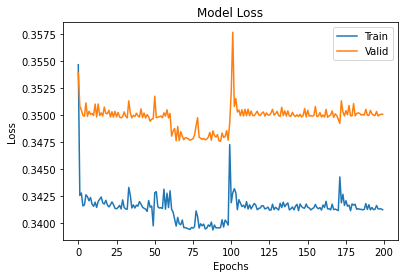

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_peak.history['dense_rmse'])
plt.plot(history_peak.history['val_dense_rmse'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
Y_pred = model.predict(X_test)
np.sqrt(np.mean(np.square(Y_pred[0][:,0]-Y_test[:,0,0])))

0.344887063224044